parser:
Where we need more BB?
1- if-else
2- while
3- for

In [1]:
import collections 
import inspect
import copy  
from collections import defaultdict

In [6]:
%run tokenizer.ipynb
%run util.ipynb


%xmode Plain
%pdb on
#verbos,
# for debug in the case of exception

class SSA(SSA_util):
    def __init__(self):
        self.SSA_current_line=0
        SSA_util.__init__(self)
    
    def emit2(self,bb,op,x=None,y=None):
        self.add_SSA_current_line()
        code_line=SSA_code(self.get_SSA_current_line(),op,x,y)
        self.node[bb]["code"].append(code_line)
    
    def compute_SSA(self,x,y,op,bb):
        if op=="MOVE":
            self.emit2(bb,op,Parenthesize(self.get_SSA_table_variable(x,bb)),Parenthesize(self.get_SSA_table_variable(y.real_value,bb)))
        if op in opCode.keys():
            if x.kind=='constant' and y==None: #let a<-1;
                self.emit2(bb,"None","#")
            elif x.kind=='var' and y==None: #let a<-1;
                self.emit2(bb,"None?",x.real_value)
            elif x.kind=='constant' and y.kind=='constant':
                x.val= eval(str(x.val) + op + str(y.val))
                #dont know the correct OP
                self.emit2(bb,"ADDI","#"+str(x.val))
            else:
                if x.kind=='constant':
                    x,y=y,x
                    self.emit2(bb,opCode[op],Parenthesize(self.get_SSA_table_variable(x.real_value,bb)),"#"+str(y.val))
                elif y.kind=='constant':
                    self.emit2(bb,opCode[op],Parenthesize(self.get_SSA_table_variable(x.real_value,bb)),"#"+str(y.val))
                else:
                    self.emit2(bb,opCode[op],Parenthesize(self.get_SSA_table_variable(x.real_value,bb)),Parenthesize(self.get_SSA_table_variable(y.real_value,bb)))
            #print("compute_SSA",x)
            return x
        elif op in ["CMP","BRA"] or op in opRel.keys():
            self._compute_SSA_branch(x,y,op,bb)
        else:
            print("!!!! could not find the operation:",op)
            
    def _compute_SSA_branch(self,x,y,op,bb):
        if op in ["CMP"]:
            if x.kind=='constant' and y.kind=='constant':
                #can be optimized to avoid either if or else BB!!
                #x.val= eval(str(x.val) + op + str(y.val))
                self.emit2(bb,"CMP","#"+str(x.val),"#"+str(y.val))
            else:
                if x.kind=='constant':
                    self.emit2(bb,"CMP","#"+str(x.val),str(self.get_SSA_table_variable(y.real_value,bb)))
                elif y.kind=='constant':
                    self.emit2(bb,"CMP",Parenthesize(self.get_SSA_table_variable(x.real_value,bb)),"#"+str(y.val))
                else:
                    self.emit2(bb,"CMP",Parenthesize(self.get_SSA_table_variable(x.real_value,bb)),Parenthesize(self.get_SSA_table_variable(y.real_value,bb)))
                
        elif op in opRel.keys():
            jump_add=self._get_BB_first_SSA_number(x)
            print(bb,opRel[op],Parenthesize(jump_add))
            self.emit2(bb,opRel[op],Parenthesize(jump_add))
        elif op in ["BRA"]:
            #jump address is the first SSA number of merge block (passed as X)
            jump_add=self._get_BB_first_SSA_number(x)
            self.emit2(bb,"BRA",Parenthesize(jump_add))
                
    def insert_phi(self,bb,var,left_line,right_line):
        print("inserting phi...")
        self.emit2(bb,'Phi',Parenthesize(left_line),Parenthesize(right_line))
        self.add_SSA_table(var,bb)   
        
    def _set_copy_propagation_SSA_table(self,x,y,bb):
        # variable x is copying y: x<-y
        if y.kind!="constant":
            try:
                self.node[bb]["SSA_table"][x].append(self.node[bb]["SSA_table"][y.real_value][-1])
            except:#there is no SSA entry for y: maybe I have initilize it to 0!
                self.node[bb]["SSA_table"][x].append(-1)
        else:
            self.node[bb]["SSA_table"][x].append(self.get_SSA_current_line())
             
    def copy_SSA_table(self,bb): #copy the parent's SSA table
        for p in self.node[bb]["parents"]:
            for k,v in self.node[p]["SSA_table"].items():
                if TEMP_VARIABLE_CORE in k: continue
                if k not in self.node[bb]["SSA_table"].keys():
                    self.node[bb]["SSA_table"][k]=copy.deepcopy(v)
                    
                if len(self.node[bb]["parents"])==1:continue #we Dont need phi for just one parent.
                elif self.node[bb]["SSA_table"][k]==v:continue #the variable SSA has not changed
                else:#insert Phi
                    self.insert_phi(bb,k,self.node[bb]["SSA_table"][k][-1],self.node[p]["SSA_table"][k][-1]) 
    
    def ASSIGNMENT_SSA_builder(self,copy_propagation,result,indent,bb):
        if copy_propagation and result.kind!="constant": #x<-y
            self.emit2(bb,"#copy propagation",indent,result.real_value)
            self._set_copy_propagation_SSA_table(indent,result,bb)
        elif result.kind=="constant": #x<-2
            self.emit2(bb,"ADDI",indent,result.val)
            self._set_copy_propagation_SSA_table(indent,result,bb)
        else: #x <- y + z
            self.add_SSA_table(indent,bb)  
    
    def check_CSE(self,dom_bb,bb):
        result=[]
        for dom_comp in self.node[dom_bb]["code"]:
            for j in self.node[bb]["code"]: 
                if dom_comp==j and dom_comp!="BRA":
                    print(dom_bb,bb,dom_comp,j,"are the same: CSE")
                    result.append((dom_bb,bb,dom_comp,j))
        return result
    
                    
    
class parser(SSA,Reg,parser_util,BB,SSA_code,Random_variable_gen):
    def __init__(self,tokens,rules):
        self.tokens=collections.deque([i for i in tokens if i.type!='COMMENT'])
        SSA.__init__(self)
        #Reg.__init__(self)
        parser_util.__init__(self)
        BB.__init__(self)   
        self.Random_variable=Random_variable_gen()
    
    def check_factor(self,bb):
        result=Result(None,None,None,None,None)
        copy_propagation=True
        if self.tokens[0].type not in ["INDENT","NUMBER","OPEN_P","call"]:
            print("error,check_factor!!!",self.tokens[0],inspect.stack()[1][3])
        if self.tokens[0].type=="INDENT":
            #TODO:what about array?
            result.kind,result.address,result.real_value='var',self.tokens[0].value,self.tokens[0].real_value
            indent=self.check_designator(bb)          
        if self.tokens[0].type=="NUMBER":
            copy_propagation=True
            result.kind,result.val='constant',self.tokens[0].value 
            self.must_parse("NUMBER")            
        if self.tokens[0].type=="OPEN_P":
            copy_propagation=False
            self.must_parse("OPEN_P")
            result=self.check_expression(bb)
            self.must_parse("CLOSE_P")
        if self.tokens[0].type=="call":
            copy_propagation=False
            self.check_funcCall()
        return result,copy_propagation
            
    
    def check_expression(self,bb):
        result_x,copy_propagation=self.check_term(bb)
        #can be optimized by adding all constant at first!
        while self.tokens[0].value in ["+","-"]:
            copy_propagation=False
            op=self.tokens[0].value
            self.must_parse("OP")
            result_y,_=self.check_term(bb)
            result_x=self.compute_SSA(result_x,result_y,op,bb)
            if result_x.kind!="constant":
                result_x.real_value=self.Random_variable.get_current_random_variable()                
                self.add_SSA_table(result_x.real_value,bb)
        self.Random_variable.next()
        return result_x,copy_propagation
        
    def check_assignment(self,bb):
        self.must_parse("let")
        indent=self.check_designator(bb)
        self.must_parse("ASSIGN")
        result_x,copy_propagation=self.check_expression(bb)
        
        self.ASSIGNMENT_SSA_builder(copy_propagation,result_x,indent,bb)
        
        
    def check_ifStatement(self,bb):
        mother_bb=bb
        
        self.must_parse("if")
        op=self.check_relation(bb)
        
        self.must_parse("then")    
        #cant use Walrus-operator cause wanted to be compatible with python 3.7-
        newbbif=self.new_bb([mother_bb])        
        #need to check:nested if , or combination with while? add newbbif= to the following!
        newbbif=self.check_stat_Sequence(newbbif)
        
        if self.tokens[0].type=="else":
            self.must_parse("else")
            newbbelse=self.new_bb([mother_bb])
            #need to check:nested if , or combination with while? add newbbif= to the following!
            newbbelse=self.check_stat_Sequence(newbbelse)
            merge_bb=self.new_bb([newbbif,newbbelse])
            self._make_bra_IF_ELSE(True,merge_bb,newbbif,newbbelse,mother_bb,op)
        else:
            merge_bb=self.new_bb([newbbif])
            self._make_bra_IF_ELSE(False,merge_bb,newbbif,None,mother_bb,op)
            
        self.must_parse("fi")                
        return merge_bb
    
    #bra at the end of mother block(mother_bb), jumping to the beginning else/merge block(newbbelse/merge_bb)!
    def _make_bra_IF_ELSE(self,has_else,merge_bb,newbbif,newbbelse,mother_bb,op):
        if has_else:#bra at the end of if block(newbbif), jumping to the beginning of merge block(merge_bb)!
            self.compute_SSA(merge_bb,None,"BRA",newbbif)        #(x,y,op,bb)
            self.compute_SSA(newbbelse,None,op,mother_bb)
        else:#conditional branch at the end of mother_BB block, to the beginning of merge block(merge_bb)!
            self.compute_SSA(merge_bb,None,op,mother_bb)
    
    def _SSA_while(self,join_node,outside_while_bb,op):        
        #I need to copy the SSA of inside_while_bb into join node, and update the SSA_code based on the updated table
        #need a heavy refactorization!
        self.copy_SSA_table(join_node)
        #need to move phi to the top:bring all the pho to the top of join_node by traversing the whole list
        aa=self.node[join_node]["code"]
        self.node[join_node]["code"]=[]
        bb=[i for i in aa if i.op=="Phi"]
        cc=[i for i in aa if i.op!="Phi"]
        
        #CHECK: need to update the SSA code: is this correct?
        print("has to update the code of ",join_node)
        print("old code=","---".join([str(j) for j in cc]))
        #why did I save the SSA numbers () in string format? what is the alternative?        
        def find_SSA_number(i,bb):
            pass
        
        for i in cc:
            try:
                aaa=int(i.x[1:-1])
                for bbb in bb:
                    ss= int(bbb.x[1:-1])
                    if ss==aaa:#bb.x is phi: the old version of variable
                        i.x=Parenthesize(int(bbb.SSA_number))
            except:
                print(i)
            try:
                aaa=int(i.y[1:-1])
                for bbb in bb:
                    ss= int(bbb.x[1:-1])
                    if ss==aaa:#bb.x is phi: the old version of variable
                        i.y=Parenthesize(int(bbb.SSA_number))
            except:
                print(i)
                
            #find_SSA_number(i,bb)
            

        dd=bb+cc
        self.node[join_node]["code"]=copy.deepcopy(dd)                  
        print("updated the code of ",join_node)
        print("new code=","---".join([str(j) for j in cc]))
        #End: need to update the SSA code: is this correct?
        #I need to add the jmp the the join block as well!
        #print("++++++",join_node,None,op,outside_while_bb)
        # RelOp jump from the end of join_node to the outside_while_bb
        self.compute_SSA(outside_while_bb,None,op,join_node)

        
    def check_whileStatement(self,bb):
        join_node=self.new_bb([bb])
        self.must_parse("while")
        op=self.check_relation(join_node)
        
        self.must_parse("do")
        inside_while_bb=self.new_bb([join_node])
        inside_while_bb_end=self.check_stat_Sequence(inside_while_bb)
        
        self.node[join_node]["parents"].append(inside_while_bb_end)#what about dominator?
        
        self.must_parse("od")        
        outside_while_bb=self.new_bb([join_node])
        
        self._SSA_while(join_node,outside_while_bb,op)
        
        return outside_while_bb
    def remove_cse(self,ii):
        dom_bb,bb,dom_comp,jj=ii
        #self.SSA_number=SSA_number
        jj.op="CSE"
        jj.x=Parenthesize(jj.SSA_number)+"CSE"
        jj.y=Parenthesize(dom_comp.SSA_number)+"CSE"
        
        replace_with=Parenthesize(dom_comp.SSA_number)
        replace=Parenthesize(jj.SSA_number)
        for i in self.node:
            for j in self.node[i]["code"]:
                if j.x==replace:
                    j.x=replace_with
                if j.y==replace:
                    j.y=replace_with
        #update SSA_table
        for i in self.node:
            for k,v in self.node[i]["SSA_table"].items():
                for cnt,vv in enumerate(v):
                    if vv==jj.SSA_number:
                        v[cnt]=dom_comp.SSA_number
        #self.cse_replace()
        pass
    
    def make_inference_graph(self):
        self.graph_inf=nx.Graph()
        live=set()
        G_reverse=self.G.reverse(copy=True)
        zero_entry=[]
        for node in G_reverse:
            if G_reverse.in_degree(node)==0:
                zero_entry.append(node)
                
        while len(G_reverse)>0:
            if len(zero_entry)==0:
                for node in G_reverse:
                    if G_reverse.in_degree(node)==0:
                        zero_entry.append(node)
            while zero_entry:
                node=zero_entry.pop()
                live=self.node[node]["live"]
                print("in_degree",node)
                print([i for i in reversed(self.node[node]["code"])])
                for inst in reversed(self.node[node]["code"]):
                    #what to do in the case of CSE optimization?
                    if "CSE" in inst.op or "BRA" in inst.op: continue # 'any' python builtin?
                    if node!=4 and inst.SSA_number not in live: continue #dead code elimination
                    # add edge to graph
                    for to_node in live:
                        self.graph_inf.add_edges_from([(to_node,inst.SSA_number)])
                    # remove current inst from the live set
                    try:live.remove(inst.SSA_number)
                    except: pass
                    # add operand of inst to the live set
                    try:
                        a=int(inst.x[1:-1])
                        live.add(a)
                    except:
                        pass
                    try:
                        a=int(inst.y[1:-1])
                        live.add(a)
                    except:
                        pass

                self.node[node]["live"].update(live)
                for p in self.node[node]["parents"]:
                    self.node[p]["live"].update(self.node[node]["live"])
                print("live=========",self.node[node]["live"],node)
                G_reverse.remove_node(node)
            
        nx.draw(self.graph_inf,with_labels=True)    
        print(nx.greedy_color(self.graph_inf))
        pass

temp+for+internalUse2
('temp+for+internalUse3', 'temp+for+internalUse3')
Exception reporting mode: Plain
Automatic pdb calling has been turned ON


0 1 2 3 0 1 2 1 1 4 1 0 1 2 4 1 3 1 inserting phi...
(1, 'blt', '(7)')
2 0 1 ('error!!!!!', 'CLOSE_C', Token(type='let', value='let', real_value=None), 'check_computation')
[3, '<-', 0, '+', 2, '}', '.']
('error!!!!!', 'POINT', Token(type='INDENT', value=3, real_value='d'), 'check_computation')
['<-', 0, '+', 2, '}', '.']
('dom_tree from entry node,', 1, [(1, 1), (2, 1), (3, 1), (4, 1)])
('Dom treee_reachable from node:', 1, set([2, 3, 4]))
('in_degree', 4)
[(11) ADD (1), (2), (8) Phi (6), (3)]
('live=========', set([1, 2, 3, 6]), 4)
('in_degree', 3)
[(7) ADD (2), #1]
('live=========', set([1, 2, 3, 6]), 3)
('in_degree', 2)
[(9) BRA (8), None, (6) ADD (4), (2)]
('live=========', set([1, 2, 3, 4]), 2)
('in_degree', 1)
[(10) blt (7), None, (5) CMP (1), (2), (4) ADD (2), #5, (3) ADD (2), (2), (2) ADDI b, 2, (1) ADDI a, 1]
('live=========', set([6]), 1)
{1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 8: 2}


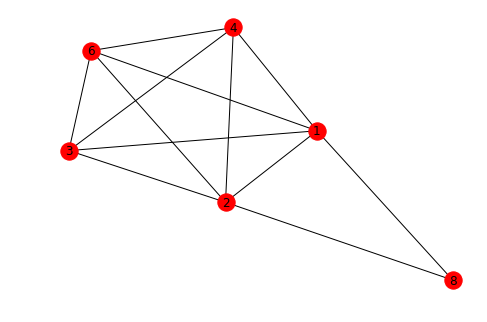

In [7]:
code='''
main
var a, b, c, d;
{
	let a <- 1;
	let b <- 2;
	let c <- b + b;
    let k <- b + 5;
	
	if a< b then
		let c <- k + b
	else
        let d <- b + 1
	fi;
    let c <- a + b
    let d <- a + c
}.'''
%matplotlib inline    
def testa(code):
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(code)
    #tk.print_tokens()
    c=parser(tk.result,rules) 
    c.check_computation()
    #c.print_bb()
    c.visulize()
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph_before_cse.png

    # these lines are for CSE: need to be refactorized!
    c.build_graph()
    c.all_dom_pair()
    c.visulize()
    
    #reg allocation:
    c.make_inference_graph()
    #nx.draw(c.graph_inf,with_labels=True)      
    
    !graph-easy grid.dot --as_dot | dot -Tpng -o graph.png
    
testa(code)

from IPython.display import Image
#Image(filename='graph.png') 



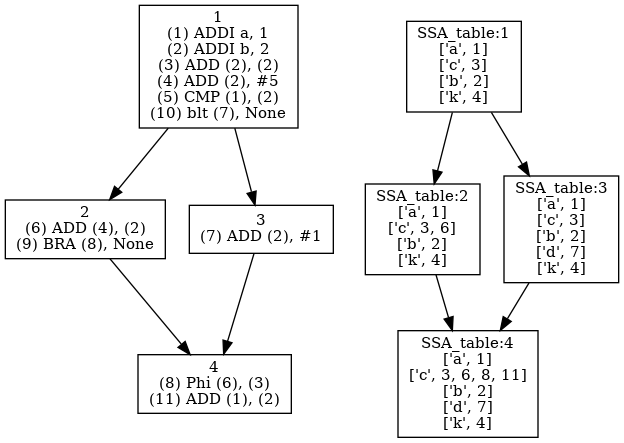

In [4]:
Image(filename='graph_before_cse.png') 
Image(filename='graph.png')

import os
path="/home/ahmad/Documents/compiler/project/testprogs/"
for files in os.listdir(path):
    print(files,"==========")
    a="".join([lines for lines in open(path+files,'r')])
    tk=Tokenizer(l_kewords,token_specification)
    tk.tokenize_program(a)
    c=parser(tk.result,rules)
    c.check_computation()
    #tk.tokenize_program(code)

x= 3 <br>
y= x+1; <br>
a= x + y; <br>
=====> <br> : first load, and then add, will preserve the original value<br>
(1) addi x,#3<br>
(2) add x1,#1; <br>
(3) move (2),y <br>
(4) add x1,y <br>
(5) move x1,a <br>
==========><br>
One pass: <br>
(1) addi x,#3 <br>
---add x,1 to SSA table <br>
(2) add (1),#1<br>
---add y,2 to SSA table <br>
(3) add (1),(2)<br>

Test021:<br>
	let a <- 1;<br>
	let b <- 2;<br>
	let a <- a * b * 7 * a;<br>
	let a <- a + b<br>
==========><br>
(1) addi a,#1<br>
(2) addi b,#2; <br>
(3) MUL (1),(2) <br>
(4) MUL (3),#7 <br>
(5) MUL (3),(1) <br>
(6) add (5),(2) <br>


In [5]:
# to do: 
#ok: deal with a<- a+b+c+d+a * b*c*d
#deal with a<- 1:
    #Addi for now!
#ok: complete the while SSA generator
    # need to refactorize the code!
    # need to check: if it works for nested while and if: not now! the bb number is wrong for now(return path)!
    # check for nested if/while almost correct! need to check more
#remove redundant computations: a<-x+y  b<-x+y
#make 'live' graph of the SSA variables
#deal with arrays
#deal with functions/procedures: 
    #function BB: ok, 
    #call
    #return value
#deal with reserved functions: write, read,...
#deal with uninitilized variables
#maybe the list of SSA_table is wrong when I merge them in joint/merge bbs. 
    #it depends on how I use it for the later step(make 'live' graph of the SSA variables)